In [2]:
import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
#uncomment the code and provide the token while running the code in run time. 
#os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'XXXXXXXXXXXXXXXXXX')

In [4]:
# Log in to HuggingFace

load_dotenv() 
hf_token = os.environ['HF_API_TOKEN']
login(hf_token, add_to_git_credential=True)

In [4]:
# More imports after HF login

from loaders1 import ItemLoader
from items import Item

In [5]:
%matplotlib inline

In [6]:
# Load in the same dataset as last time

items = ItemLoader("Appliances").load()

Loading dataset Appliances
DEBUG self.name repr: 'Appliances'
DEBUG code points: [65, 112, 112, 108, 105, 97, 110, 99, 101, 115]


Using the latest cached version of the dataset since McAuley-Lab/Amazon-Reviews-2023 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'raw_meta_Appliances' at C:\Users\shara\.cache\huggingface\datasets\McAuley-Lab___amazon-reviews-2023\raw_meta_Appliances\0.0.0\16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8 (last modified on Wed Aug  6 18:16:39 2025).
100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:18<00:00,  5.04it/s]


Completed Appliances with 28,672 datapoints in 0.4 mins


In [16]:
# Look for a familiar item..
#attributes = dir(items)
#print(attributes)
#print(items[0])
print(items[1].prompt)


How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally happy with your purchase. High-quality elements - Pivot Block

Price is $17.00


In [17]:
dataset_names = [
      "Appliances", 
]

In [18]:
from loaders1 import ItemLoader
from items import Item
items = []
for dataset_name in dataset_names:
    print(f"[LOOP] dataset_name before ItemLoader: {repr(dataset_name)}", flush=True)
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Now, time for a coffee break!!
# By the way, I put the biggest datasets first.. it gets faster.

[LOOP] dataset_name before ItemLoader: 'Appliances'
Loading dataset Appliances
DEBUG self.name repr: 'Appliances'
DEBUG code points: [65, 112, 112, 108, 105, 97, 110, 99, 101, 115]


Using the latest cached version of the dataset since McAuley-Lab/Amazon-Reviews-2023 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'raw_meta_Appliances' at C:\Users\shara\.cache\huggingface\datasets\McAuley-Lab___amazon-reviews-2023\raw_meta_Appliances\0.0.0\16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8 (last modified on Wed Aug  6 18:16:39 2025).
100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:18<00:00,  5.06it/s]


Completed Appliances with 28,672 datapoints in 0.4 mins


In [33]:
#print(items[:2])
#print(items[3].token_count)
print(f"A grand total of {len(items):,} items")

A grand total of 28,672 items


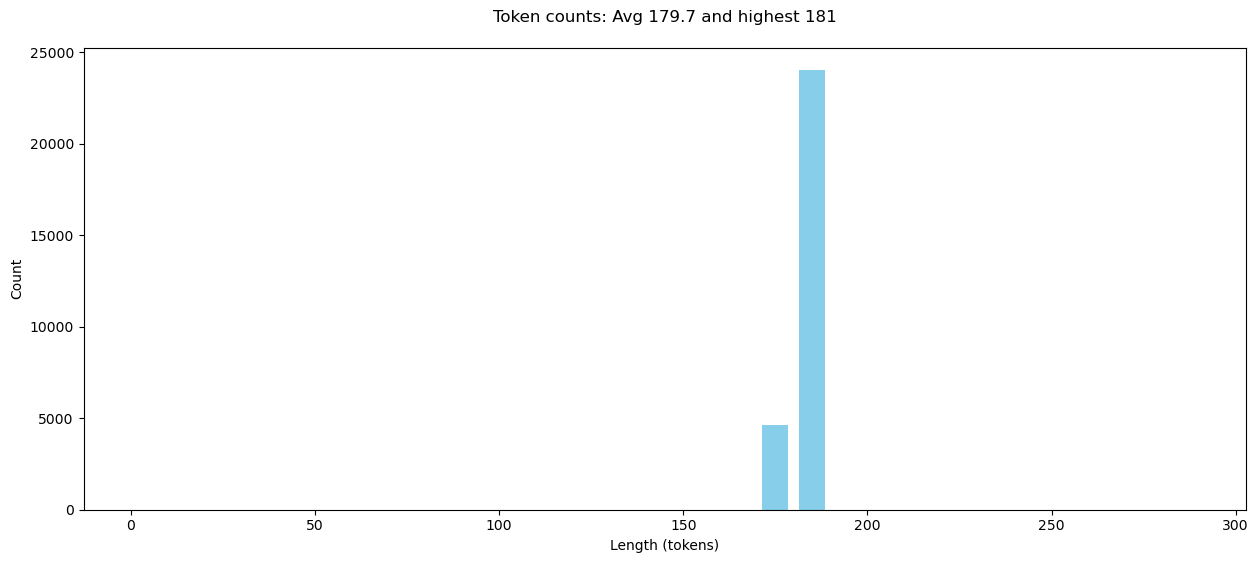

In [37]:
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

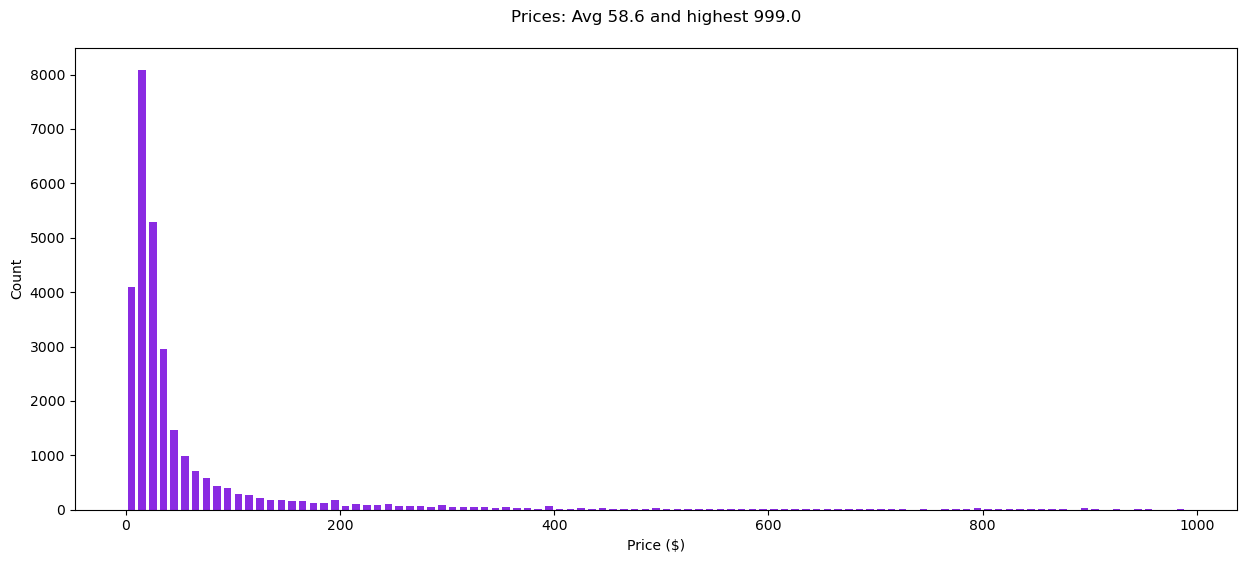

In [38]:
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

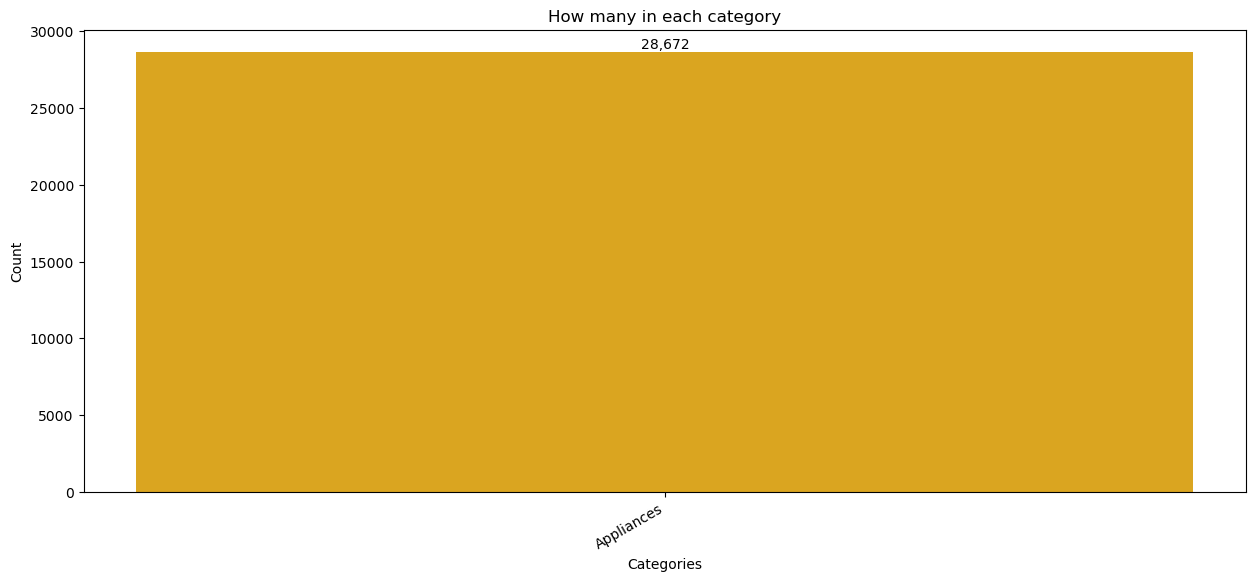

In [42]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()

counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [60]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)
#for k, v in slots.items():
#    print(f"Key: {k}, Value: {v}")  


In [68]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 28,586 items in the sample


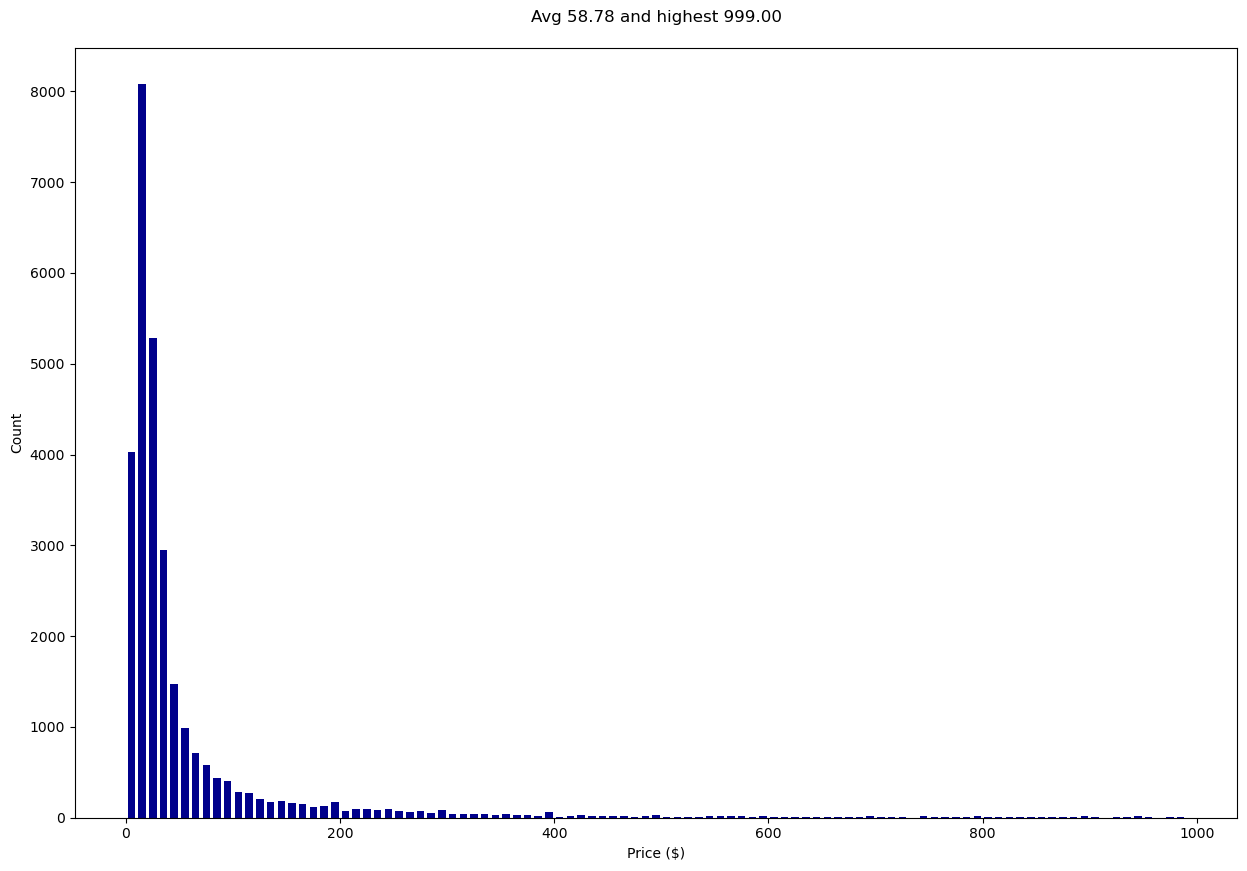

In [69]:
prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

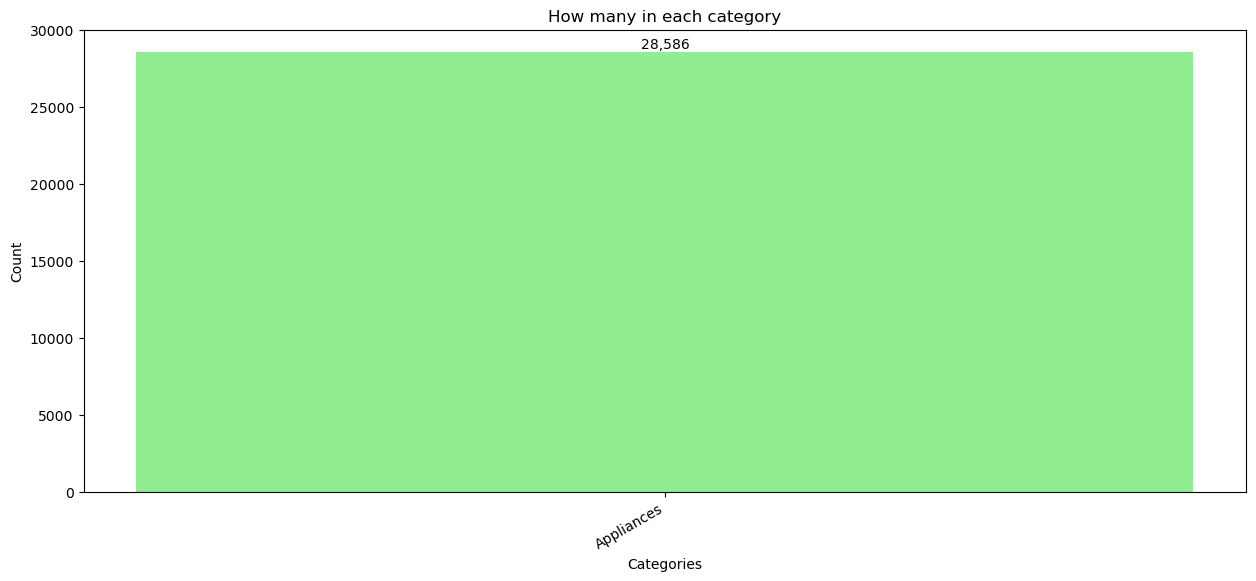

In [85]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

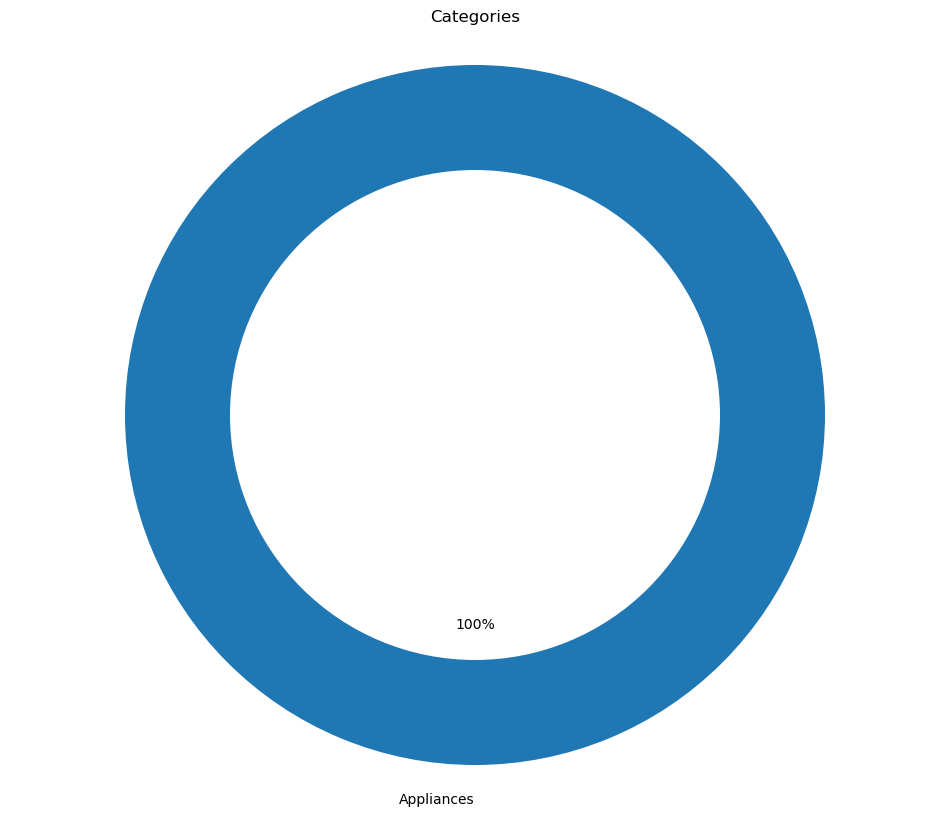

In [87]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

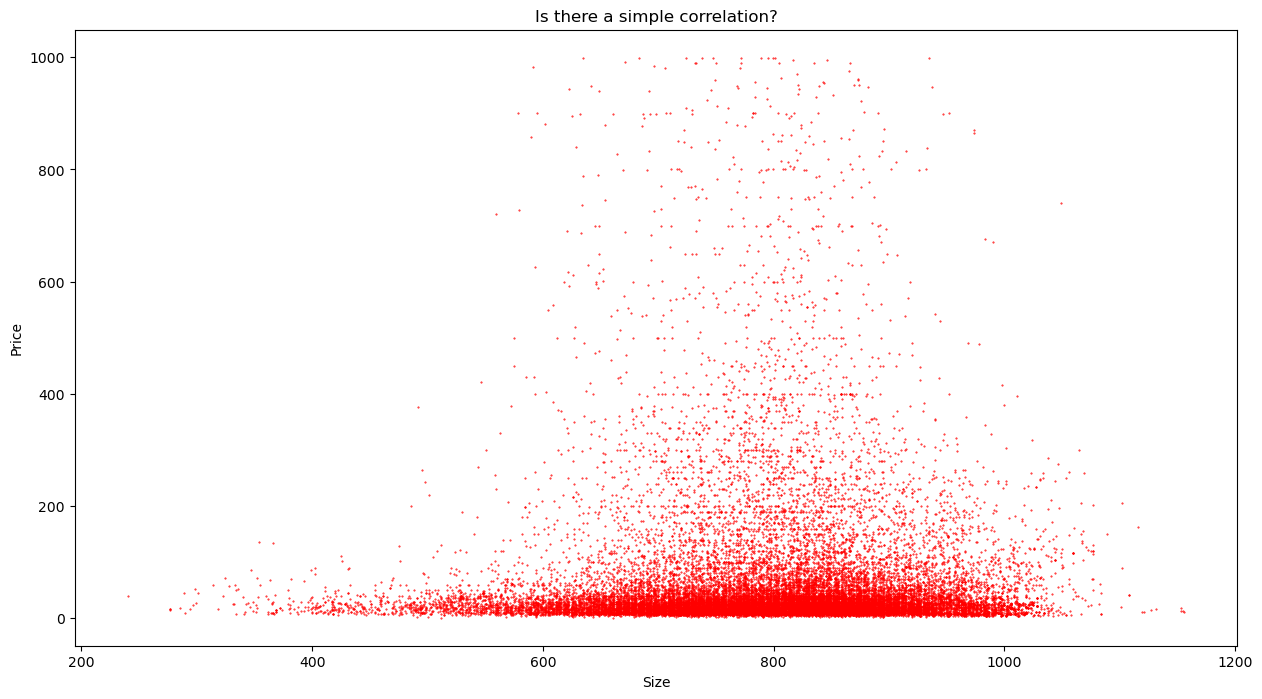

In [88]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [89]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [91]:
random.seed(42)
random.shuffle(sample)
train = sample[:28_000]
test = sample[28_000:28_586]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 28,000 items and test set of 586 items


In [92]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

36863 Washer Direct Drive Water Pump Replacement Part By AMI PARTS- Replaces 200937 34550
[Parts Number ]36863 Direct Drive Water Pump,The drain pump removes water from the washer during the drain portion of the cycle [Easy Diy Install ]This is a very simple fix and easy to do yourself,Fixes washer symptoms will not drain, unusual noises, leaking water, pumps but will not spin, not washing properly [Directly Replaces 36863, 36863, your Range is not listed above, please send us a message so we may help you obtain the correct part [Premium Quality ]The replacement part is made from durable high quality material and well-tested by

Price is $21.00


In [93]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Replacement for Refrigerator Water Filter - Compatible with Maytag Fridge Water Filter Cartridge
This is a Denali Pure Brand replacement part, NOT an OEM product. All mentions of brand names or model descriptions are made strictly to illustrate compatibility. All brand names and logos are registered trademarks of their respective owners. This product is not affiliated with any OEM brands and is not covered under any warranties offered by the original manufacturers. Any warranties for this product are offered solely by Denali Pure. Replacement for Filter Manufacturer Upstart Battery, Part Is Discontinued No, Rank Tools & Home Improvement In-Refrigerator Water Filters 6550, Available May 27, 2015, Duration 6 \tmonths, External Testing Certification ANSI, NSF, Brand Upstart Battery

Price is $


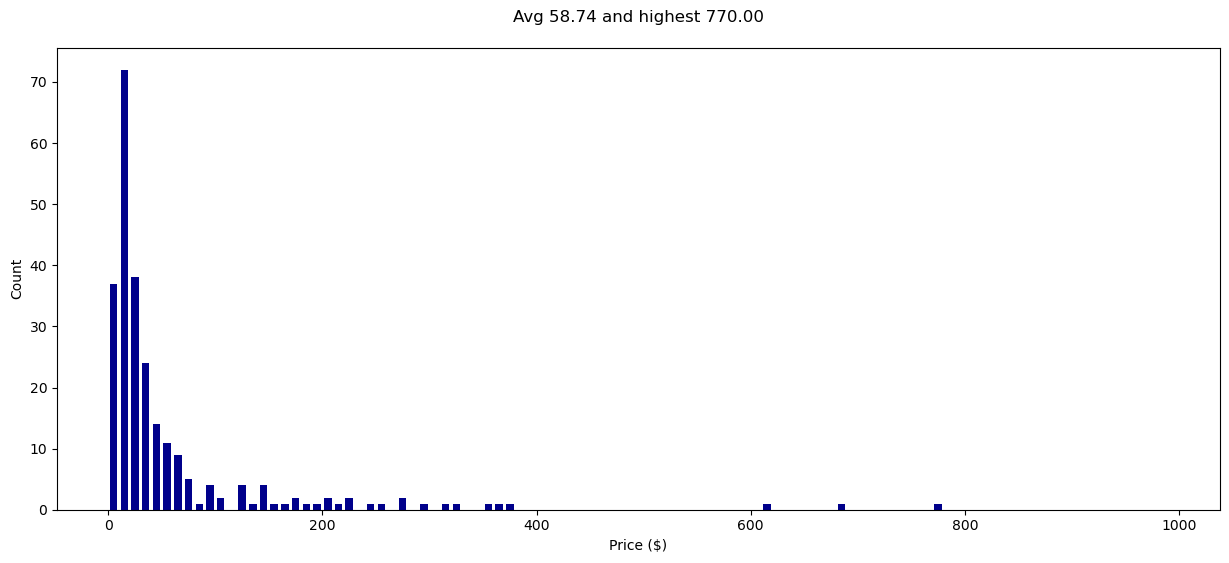

In [94]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [95]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [96]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})